In [223]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import csv
import time

def write_to_file(stuff):
    csvFile = open(r'io-util.csv', 'a')
    csv_writer = csv.writer(csvFile)
    csv_writer.writerow( stuff  )
    csvFile.close()
def my_plotter(ax, data1, data2, param_dict, title=""):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    ax.figure.set_size_inches(20, 10)
    
    ax.set_title(title, fontsize=20)
    return out
def run_query(prom_query):
    """
    Get the response of a simple query from prometheus
    Arguments:
        prom_query: Prometheus query
    Returns:
        JSON response of the query results
    """
    parameters = {
        "query": prom_query
    }
    QUERY_URL = 'http://127.0.0.1:9090/api/v1/query'

    try:
        r = requests.get(QUERY_URL, params=parameters)
        if r.ok:
            return json.loads(r.content)
        else:
            return -1
    except Exception as e:
        print(e)
        return -1


def run_query_range(query, start_range, end_range, step):
    """
    Query prometheus data for a specific range

    Arguments:
        query: Prometheus query
        start_range: range start time in Epoch Timestamp
        end_range: range end time in Epoch Timestamp
        step: Resolution in seconds
    Returns:

    """
    QUERY_RANGE_URL = 'http://127.0.0.1:9090/api/v1/query_range'
    parameters = {
        "query": query,
        "start": start_range,
        "end": end_range,
        "step": step
    }

    result = []

    try:
        r = requests.get(QUERY_RANGE_URL, params=parameters)
        if r.ok:
            g = json.loads(r.text)
            for each in g['data']['result']:
                for x in each['values']:
                    j = each['metric']['instance'] + ',' + ','.join(str(y) for y in x)
                    result.append(tuple(j.split(',')))
        else:
            return -1
    except Exception as e:
        print(e)
        return -1

    return result

Queries = {
    "mem" : "100 * (1 - ((node_memory_MemFree{job='k8s-nodes'} + node_memory_Cached{job='k8s-nodes'} + node_memory_Buffers{job='k8s-nodes'}) / node_memory_MemTotal{job='k8s-nodes'}))",
    "cpu" : "100 - (avg by (instance) (irate(node_cpu{job='k8s-nodes',mode='idle'}[2m])) * 100)",
    "io_util" : "100 * (rate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000 or irate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000)"
}

Nodes = {
    "k8master" : "172.31.15.135:9100",
    "k8node" : "172.31.15.164:9100"
}

In [224]:
# Read data from prometheus
# don't do it if csv is already populated
end_time = int('1555662402')
hrs = 16
start_time = int(end_time - 60*60*hrs)
result = run_query_range(Queries["io_util"], start_time, end_time, 60)
hosts = {x[0] for x in result}
response = {}
for host in hosts:
    response[host] = [(int(x[1]), float(x[2])) for x in result if x[0]==host]
    
values = response[Nodes["k8node"]]

write_to_file(("TIME", "UTIL"))
XY = []
for x, y in values:
    XY.append((x, y))
    write_to_file( (x, y) )

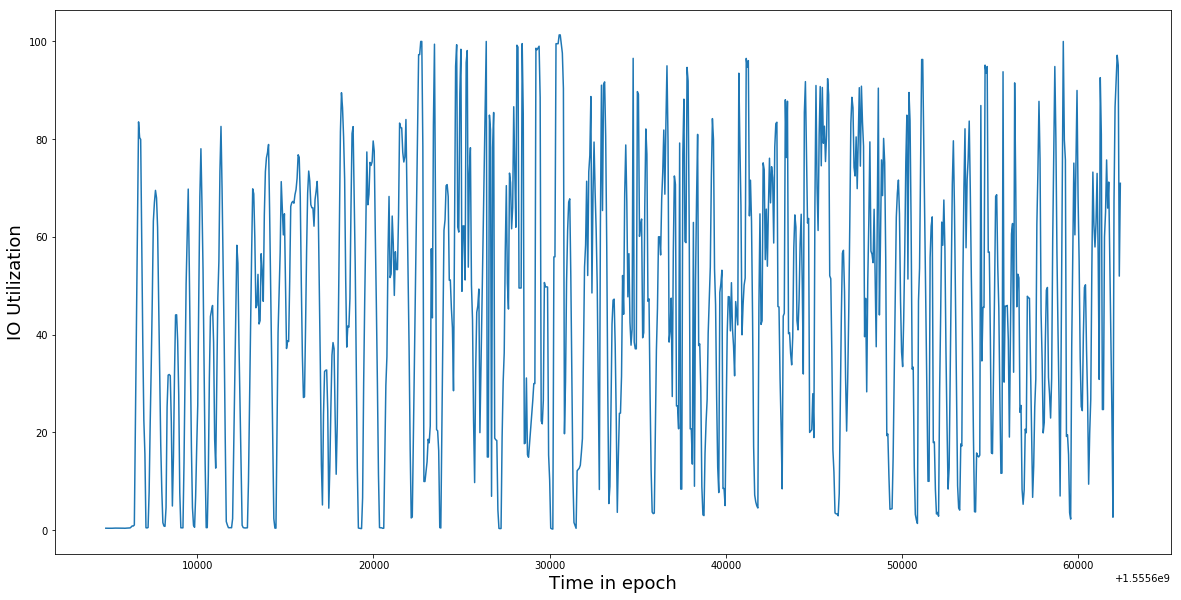

In [112]:
dataframe1 = pd.read_csv('~/Sem2/Adv Distributed Systems/project/csc724-k8s/predictor/src/io-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

# Grid Searching

In [218]:
import itertools
p=d=q=range(0,12)
pdq = list(itertools.product(p, d, q))
import warnings
warnings.filterwarnings('ignore')
pdqTrunc = [x for x in pdq if x[1] < 5 and x[2] < 5]

In [219]:
aicVal = []
for param in pdqTrunc:
    try:
        model_arima = ARIMA(y1, order=param)
        model_arima_fit = model_arima.fit()
        print(param, model_arima_fit.aic)
        aicVal.append((param, model_arima_fit.aic))
    except:
        continue

(0, 0, 0) 8901.140958761665
(0, 0, 1) 8380.880161658637
(0, 0, 2) 8196.88779634317
(0, 0, 3) 8172.211877133608
(0, 1, 0) 8252.334160020331
(0, 1, 1) 8254.289673433517
(0, 1, 2) 8244.495277429012
(0, 1, 3) 8169.9303002639335
(0, 1, 4) 8151.212706938997
(0, 2, 0) 8895.780870450591
(0, 2, 1) 8253.328634088206
(0, 2, 2) 8255.298310017326
(1, 0, 0) 8138.7827634562145
(1, 0, 1) 8125.014643129307
(1, 0, 2) 8125.599994908383
(1, 0, 3) 8125.704843643522
(1, 0, 4) 8088.566066533405
(1, 1, 0) 8254.298877009418
(1, 1, 1) 8132.080407355004
(1, 1, 2) 8116.60260907798
(1, 1, 3) 8116.586917509248
(1, 1, 4) 8116.6405326859785
(1, 2, 0) 8685.35742026901
(2, 0, 0) 8123.073887921202
(2, 0, 1) 8116.9930055929635
(2, 0, 2) 8118.9859548934
(2, 0, 4) 8087.559224009925
(2, 1, 0) 8246.300342731447
(2, 1, 1) 8113.829784396166
(2, 1, 2) 8099.691997553358
(2, 2, 0) 8567.695443816105
(3, 0, 1) 8118.9885144044765
(3, 0, 2) 8120.830710307659
(3, 0, 3) 8103.909838364332
(3, 0, 4) 8087.924733786174
(3, 1, 0) 8245.34774

In [42]:
aicVal2 = aicVal;
aicVal2.sort(key=lambda x:x[1])

# Grid search results:
[((12, 1, 4), 7730.60498843007),
 ((10, 1, 2), 7730.638273291299),
 ((11, 1, 3), 7730.7091971453665),
 ((11, 1, 4), 7730.925497158954),
 ((12, 1, 3), 7732.367321831616),
 ((13, 1, 4), 7732.425245048375),
 ((10, 1, 3), 7732.611467399402),
 ((11, 1, 2), 7732.6210237062805),
 ((6, 1, 3), 7733.2418707819525),
 ((6, 1, 1), 7733.620210234667),
 ((13, 1, 3), 7734.277033110689),
 ((12, 1, 2), 7734.392027304051),
 ((7, 1, 2), 7734.399930040607),
 ((10, 1, 4), 7734.520305582761),
 ((14, 1, 1), 7735.092944571015),
 ((10, 1, 1), 7735.443976421297),
 ((14, 1, 3), 7736.047624457451),
 ((12, 1, 1), 7736.223777101002),
 ((13, 1, 2), 7736.2696976184325),
 ((11, 1, 1), 7736.659986249118),
 ((14, 1, 2), 7737.5030045041585),
 ((13, 1, 1), 7738.149055343376),
 ((11, 0, 1), 7747.417865585301),
 ((12, 0, 1), 7749.370853177601),
 ((11, 0, 2), 7749.772276352167),
 ((12, 0, 3), 7750.055262152458),
 ((11, 0, 0), 7750.768958674309),
 ((13, 0, 1), 7751.247018811448),
 ((12, 0, 2), 7751.736611427939),
 ((13, 0, 3), 7751.781324359654),
 ((10, 0, 4), 7751.783762306752),
 ((12, 0, 4), 7751.904888898418),
 ((12, 0, 0), 7752.026005715452),
 ((11, 0, 3), 7752.0465034813315),
 ((14, 0, 0), 7752.855847323985),
 ((13, 0, 0), 7753.036127162262),
 ((13, 0, 2), 7753.381777868593),
 ((13, 0, 4), 7753.705048654014),
 ((11, 0, 4), 7753.962495503682),
 ((14, 0, 1), 7754.320978955118),
 ((14, 0, 4), 7756.545180790776),
 ((14, 0, 3), 7759.45839956051),
 ((14, 1, 0), 7787.258424962443),
 ((12, 1, 0), 7790.9311577234),
 ((13, 1, 0), 7792.833238351166),
 ((12, 2, 1), 7793.931290426728),
 ((13, 2, 2), 7795.717540869111),
 ((13, 2, 1), 7795.851241087294),
 ((13, 2, 4), 7796.09442583282),
 ((10, 1, 0), 7796.334993530321),
 ((12, 2, 2), 7796.388256596074),
 ((11, 1, 0), 7797.0804680068395),
 ((10, 2, 1), 7799.101170285554),
 ((11, 2, 2), 7799.785858221825),
 ((11, 2, 1), 7799.913365577995),
 ((10, 2, 2), 7802.987234043983),
 ((13, 2, 0), 7930.986362711079),
 ((12, 2, 0), 7934.004293702546),
 ((11, 2, 0), 7957.601561829981),
 ((10, 2, 0), 7964.579464416014),
 ((12, 2, 3), nan),
 ((13, 2, 3), nan),
 ((14, 0, 2), nan),
 ((15, 1, 4), 7734.472978309348),
 ((5, 1, 4), 7734.889537073252),
 ((7, 1, 1), 7735.2194721352025),
 ((16, 1, 4), 7735.474967465936),
 ((16, 1, 3), 7735.678351642564),
 ((14, 1, 4), 7735.766870126752),
 ((9, 1, 1), 7736.072455857811),
 ((8, 1, 2), 7736.397213400014),
 ((5, 1, 2), 7736.4398014219005),
 ((15, 1, 1), 7737.0523622303845),
 ((8, 1, 1), 7737.092127418226),
 ((9, 1, 2), 7737.167606231153),
 ((5, 1, 3), 7737.301808697999),
 ((17, 1, 4), 7737.443436785739),
 ((15, 1, 2), 7737.683143730272),
 ((15, 1, 3), 7738.044299386884),
 ((17, 1, 3), 7738.1663900718395),
 ((18, 1, 4), 7738.1863114298485),
 ((18, 1, 3), 7738.285007079699),
 ((18, 1, 2), 7738.551709149811),
 ((8, 2, 3), 7738.867834513678),
 ((16, 1, 1), 7739.050249459608),
 ((16, 1, 2), 7739.505227638012),
 ((18, 1, 1), 7740.032525715869),
 ((17, 1, 1), 7740.077025886247),
 ((17, 1, 2), 7741.067711135476),
 ((5, 1, 1), 7741.878562121054),
 ((4, 1, 4), 7742.484628429051),
 ((18, 2, 2), 7743.224962929306),
 ((1, 0, 4), 7744.6021749714655),
 ((3, 0, 4), 7745.4167419102305),
 ((4, 1, 3), 7745.457192651824),
 ((6, 1, 2), 7745.50154576798),
 ((10, 0, 1), 7745.743334570054),
 ((2, 0, 4), 7745.756204402178),
 ((8, 0, 2), 7746.0413612590255),
 ((4, 0, 4), 7747.390526715884),
 ((10, 0, 2), 7747.466998631293),
 ((9, 0, 2), 7747.700921699032),
 ((8, 0, 3), 7747.735159099899),
 ((6, 0, 0), 7747.89519465736),
 ((6, 0, 1), 7748.039731584766),
 ((6, 0, 4), 7748.15785378176),
 ((7, 0, 0), 7748.2907374496135),
 ((5, 0, 4), 7749.199367511761),
 ((8, 0, 0), 7749.4147549244135),
 ((5, 0, 3), 7749.5839466060515),
 ((8, 0, 4), 7749.6763387188785),
 ((9, 0, 0), 7750.131325173868),
 ((6, 0, 3), 7750.18651208516),
 ((10, 0, 3), 7750.4288200091105),
 ((9, 0, 3), 7750.493700804109),
 ((8, 0, 1), 7751.089679553672),
 ((10, 0, 0), 7751.281238196489),
 ((7, 0, 1), 7751.894204194834),
 ((7, 0, 3), 7752.174676797862),
 ((7, 0, 2), 7753.689052647616),
 ((15, 0, 0), 7753.797209147095),
 ((9, 0, 1), 7753.997864227991),
 ((5, 0, 2), 7754.334997290816),
 ((16, 0, 4), 7754.5329143012),
 ((5, 0, 1), 7754.559086644733),
 ((19, 0, 0), 7755.1159967141375),
 ((16, 0, 0), 7755.246134443774),
 ((7, 0, 4), 7756.318784745923),
 ((16, 0, 3), 7756.839627725858),
 ((18, 0, 1), 7756.973479557286),
 ((17, 0, 0), 7757.212658211545),
 ((9, 0, 4), 7757.329427980019),
 ((16, 0, 1), 7757.820604148543),
 ((4, 0, 3), 7757.84824367172),
 ((4, 0, 2), 7758.541118425655),
 ((6, 0, 2), 7758.548819005726),
 ((18, 0, 0), 7758.912348549677),
 ((2, 1, 2), 7759.478462345816),
 ((18, 0, 4), 7760.006696589113),
 ((16, 0, 2), 7760.46603929328),
 ((18, 0, 2), 7760.5653838507005),
 ((17, 0, 1), 7760.814150812608),
 ((19, 0, 2), 7760.901735748377),
 ((19, 0, 3), 7761.569798912611),
 ((17, 0, 2), 7761.689163561989),
 ((5, 0, 0), 7762.028009605734),
 ((4, 1, 1), 7763.495304621376),
 ((19, 0, 1), 7763.646931606929),
 ((3, 0, 3), 7765.032751497185),
 ((17, 0, 4), 7765.251819241374),
 ((2, 0, 3), 7768.304310116735),
 ((3, 1, 3), 7769.854364375386),
 ((3, 1, 4), 7770.139595945098),
 ((3, 1, 1), 7772.8683556496635),
 ((18, 1, 0), 7774.017434666655),
 ((4, 0, 1), 7774.491288636849),
 ((3, 1, 2), 7774.608165791473),
 ((2, 1, 3), 7774.612623266861),
 ((2, 1, 1), 7775.270538197619),
 ((4, 1, 2), 7775.806899204792),
 ((2, 1, 4), 7776.182231867308),
 ((2, 0, 1), 7776.21281511372),
 ((4, 0, 0), 7776.656901652163),
 ((1, 1, 4), 7777.401613939468),
 ((18, 2, 1), 7777.63325368929),
 ((1, 1, 3), 7777.650043019807),
 ((2, 0, 2), 7778.0224169656285),
 ((1, 1, 2), 7778.0724391400545),
 ((3, 0, 1), 7778.091429596401),
 ((3, 0, 0), 7782.788041644782),
 ((2, 0, 0), 7783.70044345403),
 ((15, 1, 0), 7783.992048568483),
 ((16, 1, 0), 7784.404648012542),
 ((17, 1, 0), 7785.647465926468),
 ((1, 0, 3), 7785.724916846246),
 ((1, 0, 1), 7785.7469462810095),
 ((1, 0, 2), 7785.930778142743),
 ((15, 2, 1), 7787.309255331256),
 ((16, 2, 3), 7787.361352972939),
 ((16, 2, 1), 7787.787334493394),
 ((17, 2, 1), 7789.075160966251),
 ((17, 2, 2), 7789.170295462462),
 ((14, 2, 1), 7790.438882226854),
 ((1, 1, 1), 7791.477482803008),
 ((16, 2, 2), 7791.849552444795),
 ((15, 2, 2), 7795.275732576838),
 ((14, 2, 2), 7796.31715929259),
 ((14, 2, 3), 7797.30430645307),
 ((1, 0, 0), 7797.663299498758),
 ((8, 2, 2), 7807.725290527345),
 ((7, 1, 0), 7808.216481684467),
 ((9, 1, 0), 7808.459654361908),
 ((8, 1, 0), 7808.599847995794),
 ((7, 2, 1), 7810.581145524466),
 ((9, 2, 1), 7810.994593837024),
 ((8, 2, 1), 7811.044116788369),
 ((3, 0, 2), 7811.3565657115305),
 ((15, 2, 3), 7813.0290251024235),
 ((0, 1, 4), 7814.8385141407),
 ((6, 1, 0), 7818.742492615069),
 ((6, 2, 1), 7820.878237180799),
 ((7, 2, 2), 7823.810851753691),
 ((0, 1, 3), 7833.15497520094),
 ((0, 0, 3), 7835.148836039225),
 ((5, 1, 0), 7835.6567799491295),
 ((5, 2, 1), 7837.5075276177595),
 ((0, 0, 2), 7859.102187451901),
 ((3, 2, 2), 7897.022955661983),
 ((18, 2, 0), 7898.139239148295),
 ((0, 1, 2), 7898.967358906268),
 ((3, 1, 0), 7899.560196682438),
 ((2, 1, 0), 7900.066598396907),
 ((3, 2, 1), 7900.8173988997005),
 ((4, 1, 0), 7901.042349250394),
 ((2, 2, 1), 7901.219630552301),
 ((4, 2, 1), 7902.346061336071),
 ((0, 1, 0), 7903.443631604281),
 ((0, 2, 1), 7904.404069354401),
 ((16, 2, 0), 7904.588884427825),
 ((0, 1, 1), 7905.392753219978),
 ((1, 1, 0), 7905.4019840661895),
 ((17, 2, 0), 7906.0663342895205),
 ((0, 2, 2), 7906.368499430595),
 ((15, 2, 0), 7915.07290859903),
 ((14, 2, 0), 7925.667897275705),
 ((9, 2, 0), 7989.253523093799),
 ((8, 2, 0), 7995.46123481255),
 ((7, 2, 0), 8024.239283041768),
 ((0, 0, 1), 8044.982373859184),
 ((6, 2, 0), 8071.2567553112785),
 ((5, 2, 0), 8103.893274931721),
 ((3, 2, 0), 8132.8465355381195),
 ((4, 2, 0), 8134.039184402052),
 ((2, 2, 0), 8202.375775033865),
 ((1, 2, 0), 8312.056314401094),
 ((0, 2, 0), 8521.156616722885),
 ((0, 0, 0), 8547.134250001527),
 ((18, 0, 3), nan)]

In [168]:
split_percent = 0.936
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

60
874


In [215]:
predictions = []
for i in range(0, forecast_time):
    Y_Train = y1[i:i+train_samples]
    model_arima = ARIMA(Y_Train, order=(6, 1, 3))
    model_arima_fit = model_arima.fit()
    predictions.append(model_arima_fit.forecast(steps=1)[0])

In [207]:
Y_Test = y1[873:933]

In [208]:
X_Test =  x1[873:933]

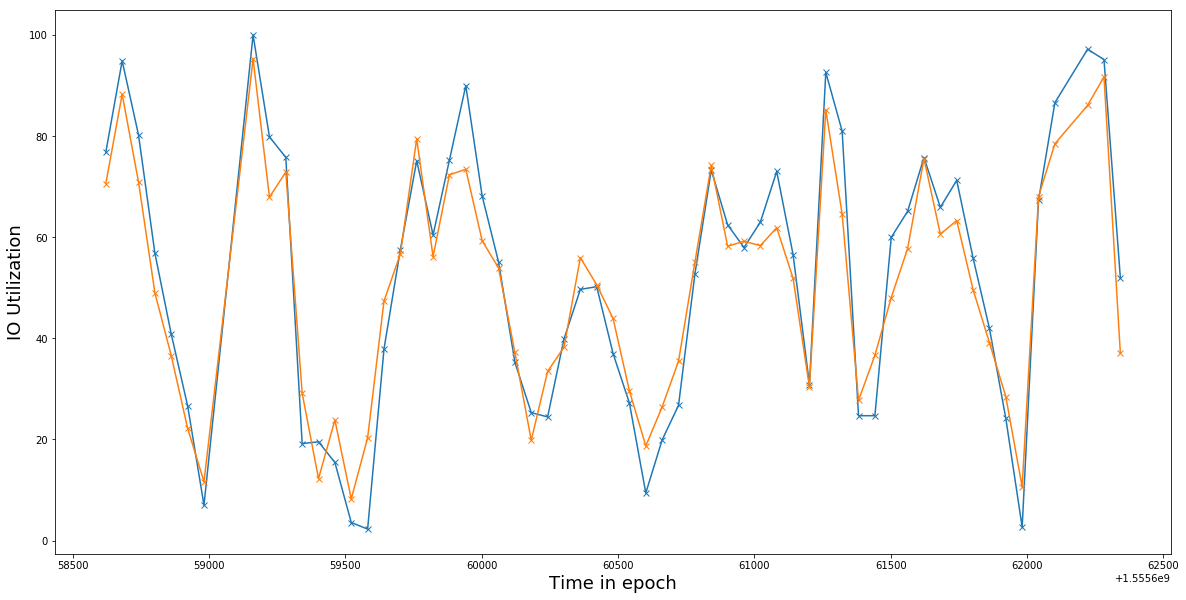

In [209]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, predictions, {'marker': 'x'})

In [216]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return sqrt(mean_squared_error(y_true, y_pred))

In [217]:
mean_absolute_percentage_error(Y_Test, predictions)

7.581013740394108

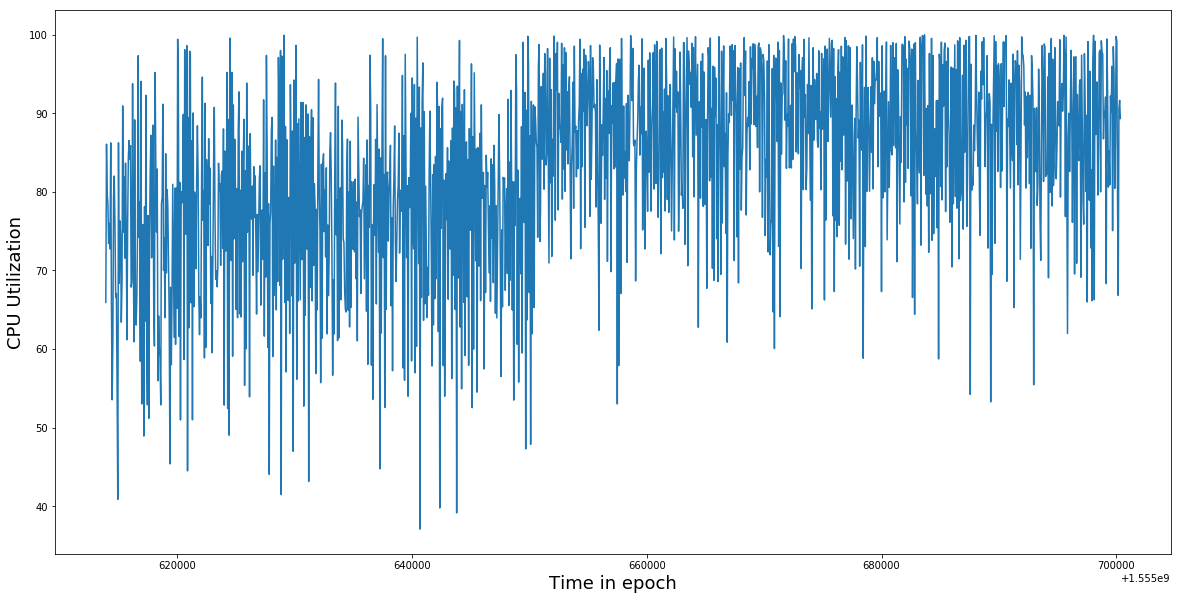

In [221]:
dataframe1 = pd.read_csv('cpu-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [222]:
import itertools
p=d=q=range(0,12)
pdq = list(itertools.product(p, d, q))
import warnings
warnings.filterwarnings('ignore')
pdqTrunc = [x for x in pdq if x[1] < 5 and x[2] < 5]
aicVal = []
for param in pdqTrunc:
    try:
        model_arima = ARIMA(y1, order=param)
        model_arima_fit = model_arima.fit()
        print(param, model_arima_fit.aic)
        aicVal.append((param, model_arima_fit.aic))
    except:
        continue

(0, 0, 0) 11351.049756688657
(0, 0, 1) 11352.81590069155
(0, 0, 2) 11137.464840387007
(0, 0, 3) 11138.686012409547
(0, 0, 4) 11136.495257685914
(0, 1, 0) 12365.264097407335
(0, 1, 1) 11004.601914570017
(0, 2, 0) 14109.829149123423
(0, 2, 1) 12366.951187634748
(1, 0, 0) 11352.641868886269
(1, 0, 1) 11015.888015822244
(1, 0, 2) 11138.411056288101
(1, 0, 3) 10863.352568148439
(1, 0, 4) 10810.22206552346
(1, 1, 0) 11435.756211556343
(1, 1, 1) 10848.154940679527
(1, 1, 2) 10843.721822378804
(1, 1, 3) 10834.828527661137
(1, 2, 0) 12718.0389606482
(1, 2, 3) 10853.199009368374
(2, 0, 0) 11142.504644690278
(2, 0, 1) 10858.209105839018
(2, 0, 2) 10853.98509055985
(2, 0, 3) 10881.888300943476
(2, 0, 4) 10849.778109906083
(2, 1, 0) 11225.64960265975
(2, 1, 1) 10841.039385874747
(2, 1, 2) 10822.444721701391
(2, 1, 3) 10686.086076505899
(2, 2, 0) 12019.723118097692
(3, 0, 0) 11070.995770125603
(3, 0, 1) 10851.474806026377
(3, 0, 2) 10832.2981713817
(3, 0, 3) 10696.656696601145
(3, 0, 4) 10698.400243